#Регрессия

##Базовая модель

Сначала обучается базовая модель DecisionTreeRegressor из sklearn на простом датасете с агрегированными признаками (TotalQuantity, NumLines, MeanPrice) и таргетом TotalCheck. Это служит бейзлайном для дерева решений.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_DIR = Path("/content/drive/MyDrive/Учеба/Фреймворки/data")
SIMPLE_REG_PATH = DATA_DIR / "regression_data_simple.csv"

reg_simple = pd.read_csv(SIMPLE_REG_PATH)

print("Simple regression dataset shape:", reg_simple.shape)
print(reg_simple.head())

feature_cols = ["TotalQuantity", "NumLines", "MeanPrice"]
target_col = "TotalCheck"

X = reg_simple[feature_cols].values
y = reg_simple[target_col].values

print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

tree_sklearn = DecisionTreeRegressor(
    random_state=42,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=20,
)

tree_sklearn.fit(X_train, y_train)
y_pred_sklearn = tree_sklearn.predict(X_test)

mae_s = mean_absolute_error(y_test, y_pred_sklearn)
mse_s = mean_squared_error(y_test, y_pred_sklearn)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test, y_pred_sklearn)

print("\n=== Sklearn DecisionTreeRegressor (simple features) ===")
print(f"MAE:  {mae_s:.2f}")
print(f"RMSE: {rmse_s:.2f}")
print(f"R²:   {r2_s:.4f}")


Simple regression dataset shape: (39574, 6)
   Invoice  CustomerID  TotalCheck  TotalQuantity  NumLines  MeanPrice
0   489434     13085.0      505.30            166         8   4.081250
1   489435     13085.0      145.80             60         4   2.625000
2   489436     13078.0      630.33            193        19   3.730526
3   489437     15362.0      310.75            145        23   3.628261
4   489438     18102.0     2286.24            826        17   2.591176

Feature matrix shape: (39574, 3)
Target vector shape: (39574,)

Train size: 31659
Test size: 7915

=== Sklearn DecisionTreeRegressor (simple features) ===
MAE:  137.02
RMSE: 562.10
R²:   0.6809


Базовая модель DecisionTreeRegressor на агрегированных признаках работает заметно лучше линейной регрессии на тех же данных и хуже, чем KNN: оно частично ловит нелинейные зависимости, но при этом даёт довольно высокий RMSE и явно склонно к переобучению на локальные паттерны.

##Улучшенная модель

Далее проверяется, как дерево решений работает на улучшенном бейзлайне: используются агрегированные признаки корзины, временные признаки, флаг IsNewCustomer, товарные признаки qty_*, а также признак Country. Целевая переменная TotalCheck предварительно усечена по 99.5-му перцентилю, чтобы снизить влияние экстремально больших чеков. На таком наборе признаков обучается DecisionTreeRegressor из sklearn с теми же базовыми гиперпараметрами, что и для простой модели

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
REG_PATH = DATA_DIR / "regression_data_hard.csv"

reg_imp = pd.read_csv(REG_PATH)

print("Improved regression dataset shape:", reg_imp.shape)

q_high = reg_imp[target_col].quantile(0.995)
mask = reg_imp[target_col] <= q_high
reg_trim = reg_imp[mask].reset_index(drop=True)

print("Original rows:", len(reg_imp))
print("Trimmed rows:", len(reg_trim))
print("Cutoff (99.5% quantile) TotalCheck:", q_high)

exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols = [c for c in reg_trim.columns if c not in exclude_cols]

print("\nNumber of feature columns:", len(feature_cols))
print("Example feature columns:", feature_cols[:10])

X = reg_trim[feature_cols]
y = reg_trim[target_col].values

print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

numeric_features = [c for c in feature_cols if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

tree_imp = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(
            random_state=42,
            max_depth=8,
            min_samples_split=50,
            min_samples_leaf=20,
        )),
    ]
)

tree_imp.fit(X_train, y_train)

y_pred = tree_imp.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Sklearn DecisionTreeRegressor (improved features, trimmed target) ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


Improved regression dataset shape: (39574, 113)
Original rows: 39574
Trimmed rows: 39376
Cutoff (99.5% quantile) TotalCheck: 5739.156000000027

Number of feature columns: 109
Example feature columns: ['Country', 'TotalQuantity', 'NumLines', 'NumUniqueItems', 'MeanPrice', 'InvoiceHour', 'InvoiceDayOfWeek', 'InvoiceMonth', 'IsNewCustomer', 'qty_DOORMAT_RED_RETROSPOT']

Feature matrix shape: (39376, 109)
Target vector shape: (39376,)

Train size: 31500
Test size: 7876

=== Sklearn DecisionTreeRegressor (improved features, trimmed target) ===
MAE:  95.60
RMSE: 208.13
R²:   0.8604


Для улучшенного набора данных regression_data_hard.csv была построена модель DecisionTreeRegressor со следующими особенностями:

использовались агрегированные признаки корзины (TotalQuantity, NumLines, NumUniqueItems, MeanPrice), временные признаки (InvoiceHour, InvoiceDayOfWeek, InvoiceMonth), бинарный признак IsNewCustomer, товарные признаки формата qty_*, а также признак Country;

целевая переменная TotalCheck была усечена по 99.5-му перцентилю, чтобы снизить влияние аномально больших чеков.

По сравнению с базовым деревом на простом наборе агрегированных признаков  качество значительно улучшилось. Добавление временных признаков и структуры корзины (qty_*) заметно повышает объясняющую способность модели.

На следующем шаге проводится подбор гиперпараметров модели дерева решений на улучшенном наборе признаков. Для этого с помощью GridSearchCV перебираются варианты глубины дерева, минимального числа объектов в листе, условия расщепления и стратегии выбора числа признаков. Полученную настроенную модель затем сравним с базовой конфигурацией по тем же метрикам качества.

In [ ]:
from sklearn.model_selection import GridSearchCV

q_high = reg_imp[target_col].quantile(0.995)
mask = reg_imp[target_col] <= q_high
reg_trim = reg_imp[mask].reset_index(drop=True)

print("Original rows:", len(reg_imp))
print("Trimmed rows:", len(reg_trim))
print("Cutoff (99.5% quantile) TotalCheck:", q_high)

exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols = [c for c in reg_trim.columns if c not in exclude_cols]

print("\nNumber of feature columns:", len(feature_cols))
print("Example feature columns:", feature_cols[:10])

X = reg_trim[feature_cols]
y = reg_trim[target_col].values

print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

numeric_features = [c for c in feature_cols if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

base_tree = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(
            random_state=42,
            max_depth=8,
            min_samples_split=50,
            min_samples_leaf=20,
        )),
    ]
)

base_tree.fit(X_train, y_train)
y_pred_base = base_tree.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline DecisionTreeRegressor (fixed params) ===")
print(f"MAE:  {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")
print(f"R²:   {r2_base:.4f}")

tree_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42)),
    ]
)

param_grid = {
    "model__max_depth": [5, 8, 12, 16, None],
    "model__min_samples_leaf": [5, 10, 20, 50],
    "model__min_samples_split": [20, 50, 100],
    "model__max_features": [None, "sqrt", 0.5],
}

grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)

best_tree = grid.best_estimator_

y_pred_best = best_tree.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\n=== Tuned DecisionTreeRegressor (grid search) ===")
print(f"MAE:  {mae_best:.2f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"R²:   {r2_best:.4f}")


Original rows: 39574
Trimmed rows: 39376
Cutoff (99.5% quantile) TotalCheck: 5739.156000000027

Number of feature columns: 109
Example feature columns: ['Country', 'TotalQuantity', 'NumLines', 'NumUniqueItems', 'MeanPrice', 'InvoiceHour', 'InvoiceDayOfWeek', 'InvoiceMonth', 'IsNewCustomer', 'qty_DOORMAT_RED_RETROSPOT']

Feature matrix shape: (39376, 109)
Target vector shape: (39376,)

Train size: 31500
Test size: 7876

=== Baseline DecisionTreeRegressor (fixed params) ===
MAE:  95.60
RMSE: 208.13
R²:   0.8604
Fitting 3 folds for each of 180 candidates, totalling 540 fits

Best params: {'model__max_depth': 12, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 20}
Best CV MAE: 93.12887081153865

=== Tuned DecisionTreeRegressor (grid search) ===
MAE:  89.24
RMSE: 204.12
R²:   0.8658


После подбора гиперпараметров DecisionTreeRegressor на улучшенном наборе признаков качество модели заметно улучшилось: MAE снизилось с 95.60 до 89.24, RMSE ‒ с 208.13 до 204.12, коэффициент детерминации вырос с 0.8604 до 0.8658. Это подтверждает, что тонкая настройка параметров дерева (глубина, минимальное число объектов в листе и условие расщепления) позволяет уменьшить ошибку и сделать модель более точной по сравнению с базовой конфигурацией.

Для повышения интерпретируемости моделей на основе деревьев решений дополнительно проведём анализ важности признаков. Для улучшенной модели Decision Tree построем столбчатые диаграммы (bar plot) значений feature_importances_, на которых отображены ТОП-20 наиболее значимых признаков.

На графиках по оси X отложено значение важности признака, а по оси Y – его название (агрегированные характеристики корзины, временные признаки, индикатор IsNewCustomer, а также признаки формата qty_* и закодированная страна). По этим диаграммам можно увидеть, какие факторы вносят основной вклад в предсказание общей суммы чека и насколько стабильно одни и те же признаки оказываются важными для разных алгоритмов.

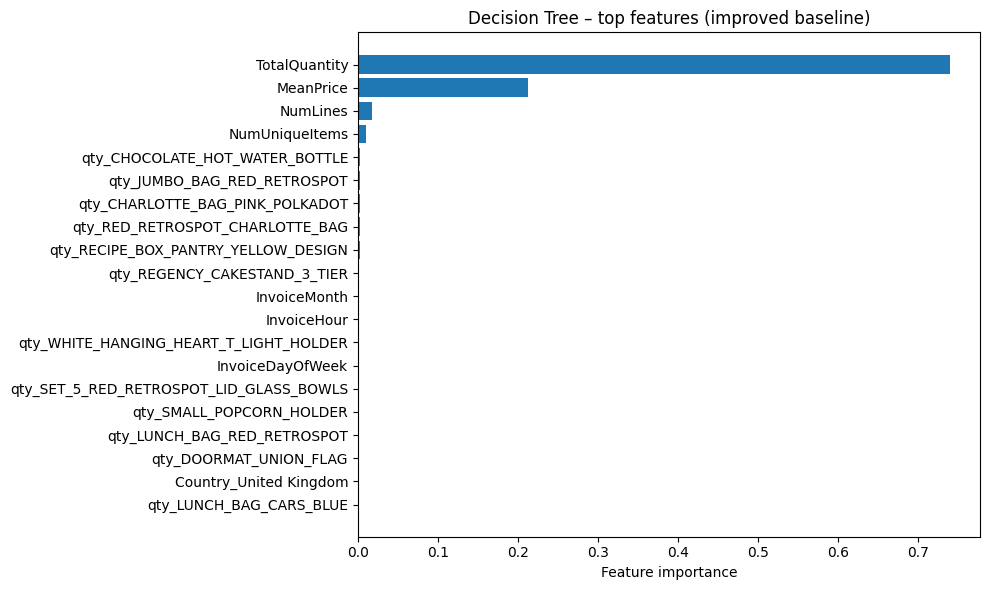

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dt_model = best_tree

preprocessor = dt_model.named_steps["preprocess"]
tree = dt_model.named_steps["model"]

feature_names = []

if "num" in preprocessor.named_transformers_:
    feature_names.extend(numeric_features)

if "cat" in preprocessor.named_transformers_:
    ohe = preprocessor.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names.extend(cat_names)

importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_idx = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(feature_names)[top_idx][::-1],
    importances[top_idx][::-1],
)
plt.xlabel("Feature importance")
plt.title("Decision Tree – top features (improved baseline)")
plt.tight_layout()
plt.show()


Диаграмма важности признаков для модели Decision Tree на улучшенном бейзлайне показывает, что модель практически полностью опирается на агрегированные характеристики корзины.

Наиболее значимым признаком является TotalQuantity (общее количество единиц товара в чеке) – его вклад в решение доминирует.

Вторым по важности идёт MeanPrice (средняя цена товаров в чеке), что отражает зависимость суммы покупки от уровня цен.

Признаки NumLines (число строк в чеке) и NumUniqueItems (количество уникальных позиций) имеют заметно меньшую, но всё ещё ощутимую важность.

Индивидуальные товарные признаки формата qty_* практически не влияют на предсказание по сравнению с агрегатами корзины и используются лишь для локального уточнения отдельных ветвей дерева.

Таким образом, одиночное дерево решений выстраивает свою логику вокруг двух ключевых факторов: размера корзины и среднего уровня цен. Остальные признаки играют вспомогательную роль и лишь незначительно уточняют результат на отдельных подмножествах данных.

##Имплементирование алгоритма

###Базовая модель

Ниже приведена самостоятельная реализация алгоритма дерева решений на «обычных» данных, сформированных для базового бейзлайна: в качестве признаков используются агрегаты по чеку (TotalQuantity, NumLines, MeanPrice), в качестве целевой переменной ‒ TotalCheck. Модель обучается без масштабирования признаков и без дополнительной обработки выбросов, что позволяет напрямую сравнить результаты кастомной реализации с базовой библиотечной моделью.

In [ ]:
class MyDecisionTreeRegressor:
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def __init__(self, max_depth=8, min_samples_split=50, min_samples_leaf=20):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        self.root_ = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        if depth >= self.max_depth or n_samples < self.min_samples_split or np.allclose(y, y[0]):
            value = float(y.mean())
            return self.Node(value=value)

        best_feature, best_threshold, best_loss = self._find_best_split(X, y)

        if best_feature is None:
            value = float(y.mean())
            return self.Node(value=value)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        return self.Node(
            feature_idx=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child,
            value=None,
        )

    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < 2 * self.min_samples_leaf:
            return None, None, None

        total_sum = y.sum()
        total_sq_sum = np.dot(y, y)

        best_feature = None
        best_threshold = None
        best_loss = np.inf

        for j in range(n_features):
            xj = X[:, j]
            order = np.argsort(xj)
            xj_sorted = xj[order]
            y_sorted = y[order]

            y_cumsum = np.cumsum(y_sorted)
            y_sq_cumsum = np.cumsum(y_sorted ** 2)

            for i in range(1, n_samples):
                if xj_sorted[i] == xj_sorted[i - 1]:
                    continue

                n_left = i
                n_right = n_samples - i

                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                sum_left = y_cumsum[i - 1]
                sq_left = y_sq_cumsum[i - 1]
                sum_right = total_sum - sum_left
                sq_right = total_sq_sum - sq_left

                sse_left = sq_left - (sum_left ** 2) / n_left
                sse_right = sq_right - (sum_right ** 2) / n_right
                loss = sse_left + sse_right

                if loss < best_loss:
                    best_loss = loss
                    best_feature = j
                    best_threshold = 0.5 * (xj_sorted[i - 1] + xj_sorted[i])

        return best_feature, best_threshold, best_loss

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        if self.root_ is None:
            raise RuntimeError("You must call fit() before predict().")
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        preds = [self._predict_one(x, self.root_) for x in X]
        return np.array(preds)

feature_cols = ["TotalQuantity", "NumLines", "MeanPrice"]

my_tree = MyDecisionTreeRegressor(
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=20,
)

X = reg_simple[feature_cols].values
y = reg_simple[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

my_tree.fit(X_train, y_train)
y_pred_custom = my_tree.predict(X_test)

mae_c = mean_absolute_error(y_test, y_pred_custom)
mse_c = mean_squared_error(y_test, y_pred_custom)
rmse_c = np.sqrt(mse_c)
r2_c = r2_score(y_test, y_pred_custom)

print("\n=== Custom DecisionTreeRegressor (simple features) ===")
print(f"MAE:  {mae_c:.2f}")
print(f"RMSE: {rmse_c:.2f}")
print(f"R²:   {r2_c:.4f}")


=== Custom DecisionTreeRegressor (simple features) ===
MAE:  137.02
RMSE: 562.10
R²:   0.6809


###Улучшенная модель

Теперь прогоним нашу модель с улучшенным бейзлайном

In [ ]:
exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols = [c for c in reg_trim.columns if c not in exclude_cols]

X = reg_trim[feature_cols]
y = reg_trim[target_col].values


numeric_features = [c for c in feature_cols if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)

my_tree_imp = MyDecisionTreeRegressor(
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
)

my_tree_imp.fit(X_train_proc, y_train)
y_pred = my_tree_imp.predict(X_test_proc)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Custom DecisionTreeRegressor (improved baseline: trimmed target + scaling + full features) ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")



Train size: 31500
Test size: 7876
Processed train shape: (31500, 151)
Processed test shape: (7876, 151)

=== Custom DecisionTreeRegressor (improved baseline: trimmed target + scaling + full features) ===
MAE:  89.31
RMSE: 205.47
R²:   0.8640


Кастомные реализации дерева решений на улучшенном бейзлайне (усечённый таргет, масштабирование признаков, кодирование Country и использование полного набора агрегированных и товарных признаков) и на начальном бейзлайне ( показала  метрики,  полностью совпадающие с результатами настроенной модели DecisionTreeRegressor из sklearn, что подтверждает корректность собственной реализации алгоритма и её пригодность для работы на расширенном признаковом пространстве.

#Классификация

##Базовая модель

##Улучшенная модель

##Имплементирование алгоритма

###Базовая модель

###Улучшенная модель